Notebook para comparar los modelos hechos del dataset ponderado (P2)

- **Tarea del backlog:** https://github.com/UCM-GIDIA-PD1/c2425-R4/issues/46
- **Propósito del código:** Comparaciones de los modelos del dataframe de peleas ponderadas (P2).
- **Autor(es):** Carlos Vallejo.  
- **Descripción y uso:** El objetivo de este notebook es ver que modelo nos da el resultado más óptimo.

In [27]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, f1_score, roc_auc_score, precision_score, recall_score, make_scorer, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import mlflow
import optuna
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import plot_tree


### Carga y preprocesamiento de los datos

Esta fase es global

In [10]:
ruta_train =  os.path.join("..","..","..", "data", "P2","train.parquet")
train = pd.read_parquet(ruta_train)

ruta_test =  os.path.join("..","..","..", "data", "P2","test.parquet")
test = pd.read_parquet(ruta_test)

test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2023-02-04,Derrick Lewis,Serghei Spivac,True,0.40,0.00,0.5864,0.3636,0.1200,0.4500,...,189.612060,8.036330e+01,25,9,0.40,0.2228,-0.307248,-0.36,0.0,-136.44
1,2023-02-04,Dooho Choi,Kyle Nelson,True,0.36,0.00,0.4824,0.6552,0.0800,0.0000,...,0.000000,0.000000e+00,6,5,0.36,-0.1728,0.133333,0.00,0.0,-61.20
2,2023-02-04,Marcin Tybura,Blagoy Ivanov,False,0.00,0.00,0.4276,0.5056,0.2000,0.2792,...,139.896213,2.207734e-07,16,6,0.00,-0.0780,-0.188071,-0.40,0.0,-56.72
3,2023-02-11,Tyson Pedro,Modestas Bukauskas,True,0.60,0.00,0.6544,0.4112,0.0000,0.0000,...,24.394312,0.000000e+00,8,4,0.60,0.2432,0.000000,0.40,0.0,16.88
4,2023-02-11,Islam Makhachev,Alexander Volkanovski,False,0.36,0.24,0.6300,0.5844,0.7576,0.1200,...,322.872251,5.342818e+02,13,12,0.12,0.0456,0.130692,1.16,-0.8,5.28


## BASELINE

Como modelo base creamos un modelo que predice que gana el peleador que más puntos tenga.

In [29]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"]

X_train_baseline = train.drop(columns=columnasQuitar)
y_train_baseline = train['WINNER']
X_test_baseline = test.drop(columns=columnasQuitar)
y_test_baseline = test['WINNER']

y_pred_baseline = (X_test_baseline["Puntos_A"] - X_test_baseline["Puntos_B"]) < 0

f1_score(y_test_baseline, y_pred_baseline)

0.484375

## Árbol de decisión

Primero seleccionamos las variables a utilizar. En el caso del árbol escogemos todas excepto los nombres de los peleadores y la fecha de la pelea.

In [12]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"]

X_train_arbol = train.drop(columns=columnasQuitar)
y_train_arbol = train['WINNER']
X_test_arbol = test.drop(columns=columnasQuitar)
y_test_arbol = test['WINNER']

Ahora creamos el modelo teniendo en cuenta los hiperparámetros utilizados para crear el modelo más óptimo.

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.61      0.54      0.57       327
        True       0.50      0.57      0.53       267

    accuracy                           0.55       594
   macro avg       0.55      0.56      0.55       594
weighted avg       0.56      0.55      0.55       594

Variables con importancia en el modelo: SIG_STR_B, Importancia: 0.13480
Variables con importancia en el modelo: STR_HEAD_B_x, Importancia: 0.25487
Variables con importancia en el modelo: STR_BODY_B_y, Importancia: 0.08930
Variables con importancia en el modelo: GRAPPLER_A, Importancia: 0.09446
Variables con importancia en el modelo: Racha_A, Importancia: 0.28154
Variables con importancia en el modelo: Puntos_A, Importancia: 0.14502


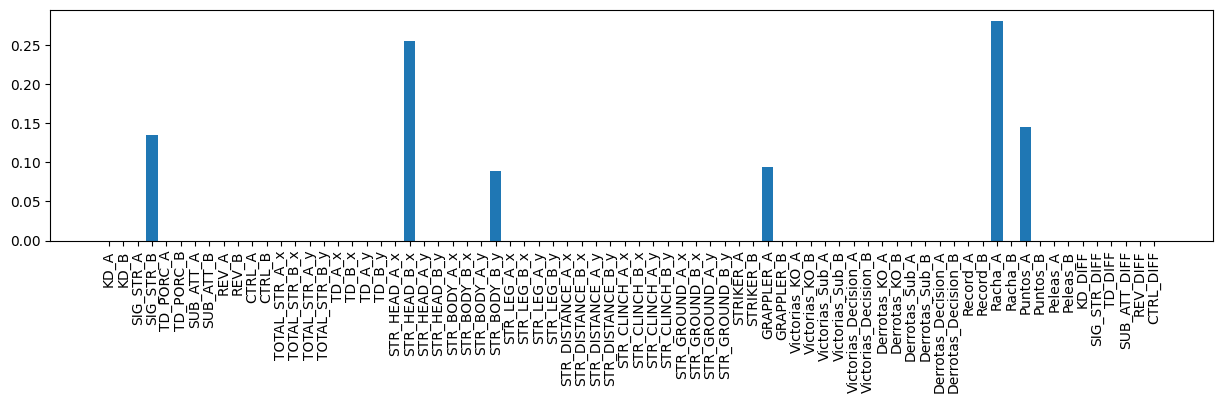

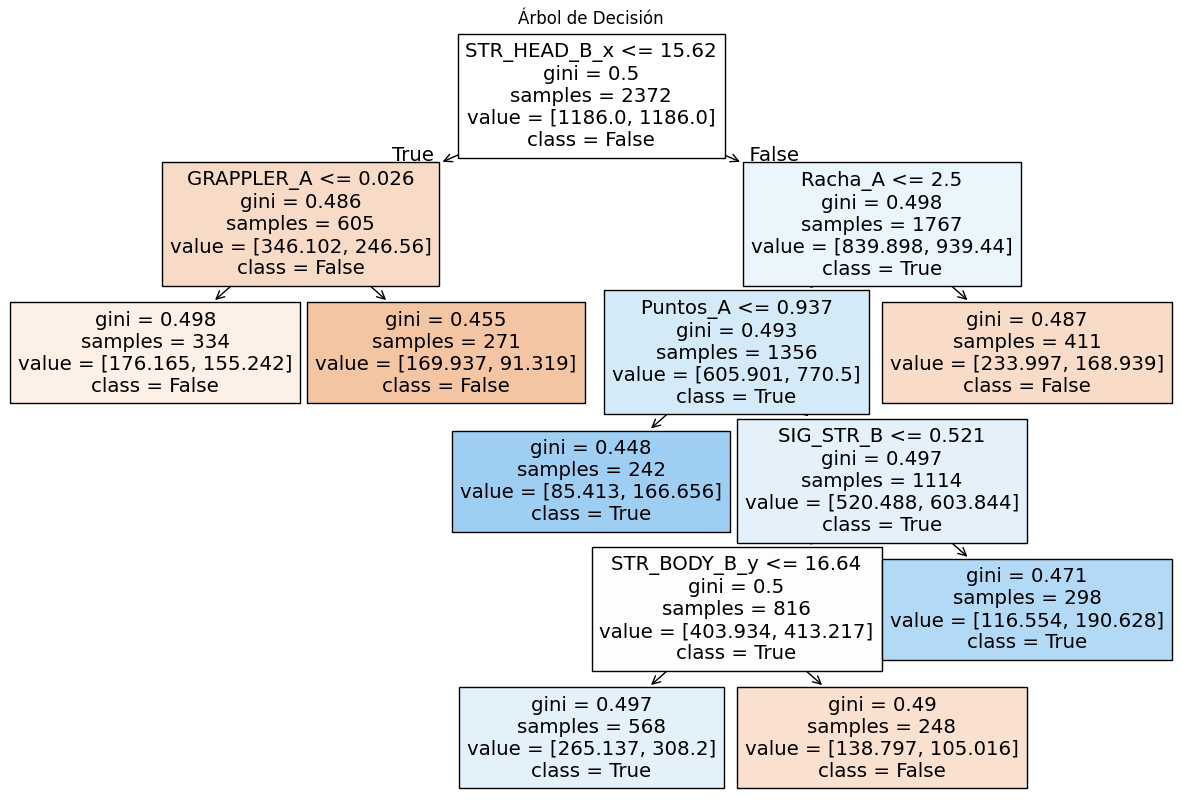

In [31]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_arbol), y=y_train_arbol)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
tscv = TimeSeriesSplit(n_splits=5)
f1_scorer = make_scorer(f1_score, average='macro')

# Definir modelo base
arbol = DecisionTreeClassifier(
    criterion = 'gini',  # Función para medir la calidad de la división
    max_depth = 5,  # Profundidad máxima del árbol
    min_samples_split = 2,  # Mínimo de muestras para dividir un nodo
    min_samples_leaf = 1,  # Mínimo de muestras en una hoja
    min_weight_fraction_leaf = 0.1,
    splitter = 'best',
    class_weight = class_weight_dict,  # Ajuste de pesos por clase
    max_features = None,
    random_state  =42    
)


# Entrenar el modelo
arbol.fit(X_train_arbol, y_train_arbol)

y_pred_arbol = arbol.predict(X_test_arbol)

print("Reporte de clasificación:")
print(classification_report(y_test_arbol, y_pred_arbol))

importance = arbol.feature_importances_
feature_names=X_train_arbol.columns
for i,v in enumerate(importance):
	if v > 0:
	    print('Variables con importancia en el modelo: %s, Importancia: %.5f' % (feature_names[i],v))

#Visualización de las variables más importantes
plt.figure(figsize=(15, 3))
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 90)
plt.show()

#Visualización del árbol
plt.figure(figsize=(15, 10))
plot_tree(arbol, filled=True, feature_names=X_train_arbol.columns, class_names=[str(i) for i in np.unique(y_train_arbol)])
plt.title('Árbol de Decisión')
plt.show()


Viendo el modelo del árbol de decisión, observamos que las variables "STR_HEAD_B_x" y "STR_BODY_B_y" juntas tienen la mitad de la importancia del modelo, y que además de estas 2, solo hay 4 que tienen algo de peso. Esto resulta interesante para ver si estas variables tienen importancia parecida en los otros modelos. Ademas, como se puede ver en las métricas, el f1-score es mayor que en el modelo base, por lo que vamos por buen camino.

## XGboost

Las variables seleccionadas son las mismas que en el árbol de decisión.

In [14]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"]

X_train_xgboost = train.drop(columns=columnasQuitar)
y_train_xgboost = train['WINNER']
X_test_xgboost = test.drop(columns=columnasQuitar)
y_test_xgboost = test['WINNER']

Creamos el modelo teniendo en cuenta los mejores parámetros obtenidos en el notebook "XGBoost_pond.ipynb"

In [23]:
# Parámetros fijos
params = {
    'n_estimators': 350,
    'max_depth': 37,
    'learning_rate': 0.014525356301837976,
    'subsample': 0.6223758299538741,
    'colsample_bytree': 0.5603666759669468,
    'gamma': 0.4820740200787993,
    'min_child_weight': 31,  
    'scale_pos_weight': np.float64(1.2905829596412555),
    'reg_alpha': 0.1,
    'tree_method': 'exact',
    'grow_policy': 'lossguide',
    'random_state': 42
}

tscv = TimeSeriesSplit(n_splits=5)
xgboost = XGBClassifier(**params)

xgboost.fit(X_train_xgboost, y_train_xgboost)

y_pred_xgboost = xgboost.predict(X_test_xgboost)

print("Reporte de clasificación:")
print(classification_report(y_test_xgboost, y_pred_xgboost))    

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.62      0.58      0.60       327
        True       0.52      0.56      0.54       267

    accuracy                           0.57       594
   macro avg       0.57      0.57      0.57       594
weighted avg       0.58      0.57      0.58       594



## Regresión logística

En regresión logística sí eliminamos variables (para ver el proceso, está en "regresion_logistica_P2_telmo.ipynb").

In [16]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER",'TD_B_y', 'GRAPPLER_B', 'STR_CLINCH_A_y', 'GRAPPLER_A', 'STR_HEAD_B_y', 'TD_A_y', 'STR_BODY_B_y', 'STR_HEAD_B_x', 'STR_DISTANCE_A_x', 'STR_HEAD_A_y', 'TOTAL_STR_B_y', 'STR_HEAD_A_x', 'STR_DISTANCE_A_y', 'STR_CLINCH_B_y', 'TOTAL_STR_A_y', 'STR_GROUND_B_y', 'STR_DISTANCE_B_x', 'STR_DISTANCE_B_y', 'TD_A_x', 'STR_GROUND_A_y', 'STR_BODY_A_y']

X_train_rl = train.drop(columns=columnasQuitar)
y_train_rl = train['WINNER']
X_test_rl = test.drop(columns=columnasQuitar)
y_test_rl = test['WINNER']

In [24]:
model = LogisticRegression(
    random_state=42,
    max_iter=1000,  # Aumentamos las iteraciones para asegurar convergencia
    solver='saga',  # 'saga' soporta L1 y L2
    C=0.6556635377191836,  # Valor específico para C
    penalty='l1'  # Usamos L1 como penalización
)

# Pipeline sin características polinomiales si no es necesario
rl = make_pipeline(
    model
)

# Ajustar el modelo con los datos de entrenamiento
rl.fit(X_train_rl, y_train_rl)

y_pred_rl = rl.predict(X_test_rl)

print("Reporte de clasificación:")
print(classification_report(y_test_rl, y_pred_rl)) 


Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.63      0.70      0.66       327
        True       0.57      0.49      0.53       267

    accuracy                           0.61       594
   macro avg       0.60      0.60      0.60       594
weighted avg       0.60      0.61      0.60       594



c:\Users\Equipo\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
